# D - End-to-End ML Part 3: Random Forest + Explainable AI

Environment für dieses Notebook: `ads-ml-full` (*requirements-py3.11-ads-ml-full.txt*).


## Daten einlesen

In [2]:
from repml.datasets.trees_ber import prepare_trees_ber

data, labeled, unlabeled = prepare_trees_ber()

## Trainings- und Testdaten

In [3]:
from sklearn.model_selection import train_test_split

y = "pflanzjahr"
X = labeled.columns.to_list()
X.remove(y)
train_data, test_data = train_test_split(
    labeled, test_size=0.2, random_state=42, stratify=labeled["gattung_deutsch"]
)

In [4]:
cols_subset_3 = ["kronedurch", "stammumfg", "baumhoehe", "bezirk", "baumart"]

## Versuch 3: Random Forest

Wir verwenden Feature Namen wieder, mit Pandas Output klappt das einfacher.

In [5]:
from sklearn import set_config

set_config(transform_output="pandas")

Prep A und B sind ähnlich zu Versuch 2.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

ct_3a = ColumnTransformer(
    transformers=[
        ("imp", IterativeImputer(random_state=42), ["kronedurch", "stammumfg", "baumhoehe"]),
    ],
    remainder="passthrough",
)
ct_3b = ColumnTransformer(
    transformers=[
        (
            "scale",
            QuantileTransformer(output_distribution="normal"),
            ["imp__kronedurch", "imp__stammumfg", "imp__baumhoehe"],
        ),
        ("ohe", OneHotEncoder(sparse_output=False), ["remainder__bezirk", "remainder__baumart"]),
    ],
)

In [7]:
from sklearn.ensemble import RandomForestRegressor

est_3 = RandomForestRegressor(
    random_state=42, min_samples_split=100, min_samples_leaf=50, max_features=10, max_depth=5
)

In [8]:
from sklearn.pipeline import Pipeline

pipeline_3 = Pipeline(steps=[("prep_a", ct_3a), ("prep_b", ct_3b), ("model", est_3)])

In [9]:
pipeline_3.fit(X=train_data[cols_subset_3], y=train_data[y])

Pipeline(steps=[('prep_a',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp',
                                                  IterativeImputer(random_state=42),
                                                  ['kronedurch', 'stammumfg',
                                                   'baumhoehe'])])),
                ('prep_b',
                 ColumnTransformer(transformers=[('scale',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  ['imp__kronedurch',
                                                   'imp__stammumfg',
                                                   'imp__baumhoehe']),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['remainder__bezirk',
                                                   'remainder__baumart'])])),
                ('model',
                 RandomForestRegressor(max_depth=5, max_features=10,
                                       min_samples_leaf=50,
                                       min_samples_split=100,
                                       random_state=42))])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator=pipeline_3, X=train_data[cols_subset_3], y=train_data[y], cv=5)

array([0.70328452, 0.70761906, 0.70042313, 0.69802397, 0.69707577])

In [11]:
pipeline_3.score(X=test_data[cols_subset_3], y=test_data[y])

0.6971931827664278

In [12]:
pipeline_3.predict(X=unlabeled[X])

array([1995.81037311, 1981.73848531, 1979.23920999, ..., 1939.92020434,
       1983.99698359, 1964.8131371 ])

## Explainable AI mit SHAP (SHapley Additive exPlanations)

Was ist für das passable Ergebnis verantwortlich?

https://shap.readthedocs.io/en/latest/index.html

[Samuele Mazzanti auf Medium: Shap Explained](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)

In [13]:
transformed_test_3 = pipeline_3[:-1].transform(X=test_data[cols_subset_3])
transformed_test_3.shape

(55077, 20)

In [14]:
import shap

explainer_3 = shap.TreeExplainer(model=est_3)
shap_values_test_3 = explainer_3.shap_values(X=transformed_test_3)

Was hat das Modell gelernt?

In [15]:
explainer_3.expected_value

array([1974.29088395])

In [16]:
train_data["pflanzjahr"].mean()

1974.2837222603005

### SHAP Beeswarm Plot
Jeder SHAP Wert pro Feature.

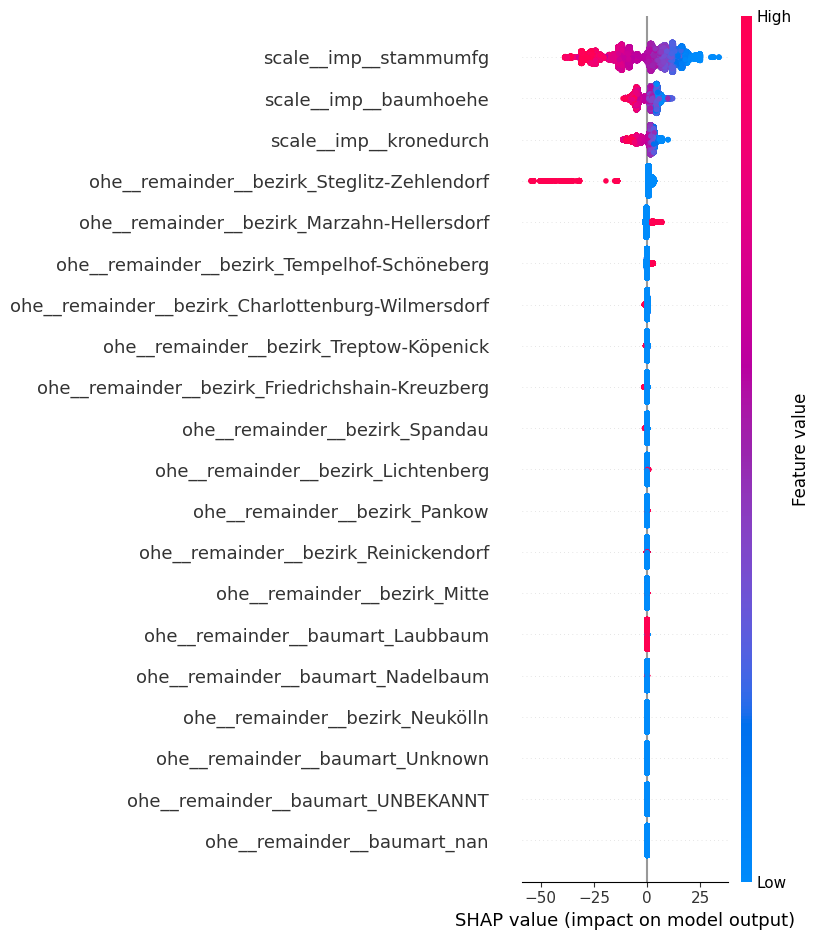

In [19]:
shap.summary_plot(
    shap_values=shap_values_test_3,
    features=transformed_test_3,
    feature_names=transformed_test_3.columns,
)

### SHAP Bar Plot
Mean absolute value der SHAP Werte pro Feature

Wir brauchen für den Bar Plot nicht die rohen Shap Values, sondern ein Explanation Objekt.

In [20]:
explanation_3 = explainer_3(X=transformed_test_3)

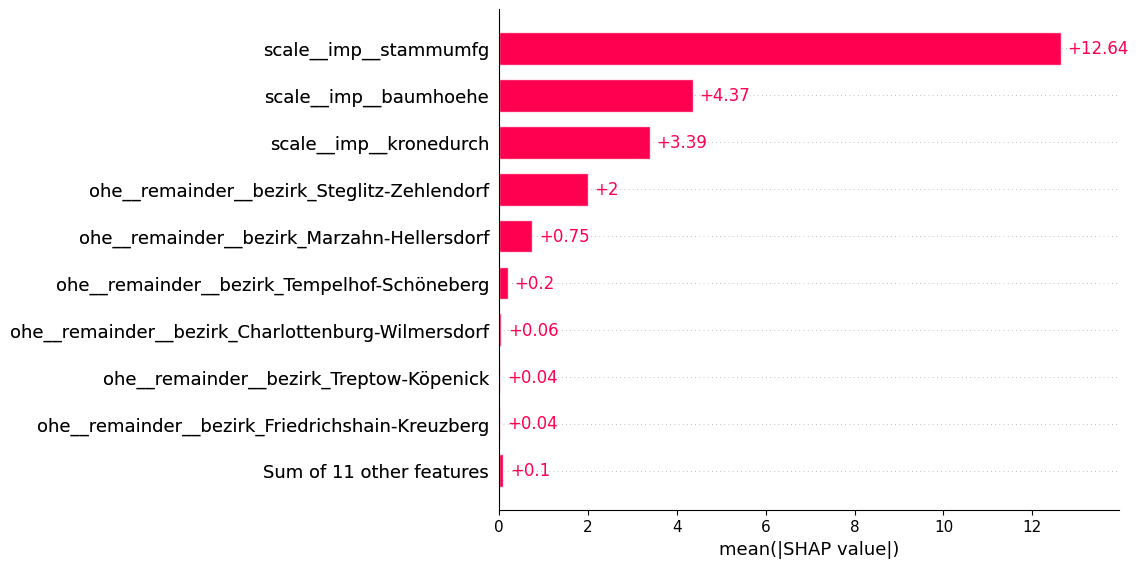

In [21]:
shap.plots.bar(shap_values=explanation_3)

## Shap Deep Dive

Ist der Durchschnitt in den SHAP Werten je Feature ca. bei null?

In [23]:
pd.DataFrame(shap_values_test_3, columns=transformed_test_3.columns)

,scale__imp__kronedurch,scale__imp__stammumfg,scale__imp__baumhoehe,ohe__remainder__bezirk_Charlottenburg-Wilmersdorf,ohe__remainder__bezirk_Friedrichshain-Kreuzberg,ohe__remainder__bezirk_Lichtenberg,ohe__remainder__bezirk_Marzahn-Hellersdorf,ohe__remainder__bezirk_Mitte,ohe__remainder__bezirk_Neukölln,ohe__remainder__bezirk_Pankow,ohe__remainder__bezirk_Reinickendorf,ohe__remainder__bezirk_Spandau,ohe__remainder__bezirk_Steglitz-Zehlendorf,ohe__remainder__bezirk_Tempelhof-Schöneberg,ohe__remainder__bezirk_Treptow-Köpenick,ohe__remainder__baumart_Laubbaum,ohe__remainder__baumart_Nadelbaum,ohe__remainder__baumart_UNBEKANNT,ohe__remainder__baumart_Unknown,ohe__remainder__baumart_nan
0,2.937817,11.521386,4.164417,0.052630,0.012726,0.086833,-0.449135,-0.001994,-0.000118,-0.008090,0.009718,0.017229,0.577917,-0.057667,0.009831,-0.000798,0.000396,0.0,0.0,0.0
1,1.608316,15.445475,-4.096033,0.043558,0.012108,0.003698,-0.288870,-0.003061,-0.000118,0.156666,0.000353,0.010136,0.794855,-0.076252,0.039439,-0.001203,0.000445,0.0,0.0,0.0
2,4.382487,13.216192,4.202388,0.038739,0.012726,-0.008998,-0.380781,-0.001994,-0.000118,-0.007449,0.005765,-0.164721,0.582961,-0.058961,0.005807,-0.000750,0.002401,0.0,0.0,0.0
3,1.710394,2.156331,2.125655,0.030780,0.012726,0.120603,-0.510705,-0.001994,-0.000118,-0.008500,0.005255,0.017744,0.567877,-0.127771,0.030223,-0.001236,0.000503,0.0,0.0,0.0
4,-3.039782,-13.190883,-5.665403,0.012817,0.014295,-0.005986,-0.290773,0.003566,-0.000118,0.043410,-0.004896,0.013319,2.103919,-0.179683,0.028114,-0.001603,0.000070,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55072,1.005196,-12.485828,1.346971,0.015049,0.020001,-0.019637,-0.638372,-0.002218,0.001591,-0.007389,0.007182,0.038753,1.474064,-0.146718,0.019635,-0.000927,0.000608,0.0,0.0,0.0
55073,2.987663,11.977676,4.023732,0.047915,0.012726,-0.006361,-0.450415,-0.001994,-0.000118,0.043307,0.009718,0.017679,0.577302,-0.057253,0.009831,-0.000750,0.000396,0.0,0.0,0.0
55074,3.402353,17.235994,5.591458,0.046298,0.012002,-0.007836,1.975676,-0.001994,-0.000396,-0.007724,0.030847,0.016285,0.590234,-0.041824,0.004070,-0.000527,0.001629,0.0,0.0,0.0
55075,0.756276,8.627314,1.979719,0.044259,0.012632,-0.004911,2.873514,-0.001994,-0.000118,-0.010603,0.006022,0.012393,0.605187,-0.066160,0.023529,-0.000284,0.001502,0.0,0.0,0.0


In [22]:
import pandas as pd

shap_values_test_feat_sums = pd.DataFrame(
    shap_values_test_3, columns=transformed_test_3.columns
).sum()
shap_values_test_feat_sums

scale__imp__kronedurch                                8429.813571
scale__imp__stammumfg                               -35188.071657
scale__imp__baumhoehe                                10836.482397
ohe__remainder__bezirk_Charlottenburg-Wilmersdorf       49.334930
ohe__remainder__bezirk_Friedrichshain-Kreuzberg        116.630289
ohe__remainder__bezirk_Lichtenberg                    -185.885435
ohe__remainder__bezirk_Marzahn-Hellersdorf            -717.777868
ohe__remainder__bezirk_Mitte                           -88.451750
ohe__remainder__bezirk_Neukölln                         -4.490603
ohe__remainder__bezirk_Pankow                          -32.517454
ohe__remainder__bezirk_Reinickendorf                    66.316086
ohe__remainder__bezirk_Spandau                         133.605552
ohe__remainder__bezirk_Steglitz-Zehlendorf           17823.137792
ohe__remainder__bezirk_Tempelhof-Schöneberg           -254.386680
ohe__remainder__bezirk_Treptow-Köpenick                -11.092771
ohe__remai

Pro Feature, nein! Über alle hinweg?

In [24]:
shap_values_test_feat_sums.sum()

927.6288612898409

Nah dran. Aber es handelt sich auch um die Testdaten. Dennoch ist der Ausgangspunkt, also der Expected Wert von ~1974.2 , gut gewählt! Zur Einordnung noch der Absolutwert an Shap Values.

In [25]:
shap_values_test_feat_sums.abs().sum()

73983.01237273535

In [26]:
transformed_train_3 = pipeline_3[:-1].transform(X=train_data[cols_subset_3])
transformed_train_3.shape

(220307, 20)

In [27]:
shap_values_train_3 = explainer_3.shap_values(X=transformed_train_3)
shap_values_train_3.shape

(220307, 20)

In [28]:
shap_values_train_feat_sums = pd.DataFrame(
    shap_values_train_3, columns=transformed_train_3.columns
).sum()
shap_values_train_feat_sums

scale__imp__kronedurch                                31804.303387
scale__imp__stammumfg                               -147435.668828
scale__imp__baumhoehe                                 42306.180228
ohe__remainder__bezirk_Charlottenburg-Wilmersdorf       215.943912
ohe__remainder__bezirk_Friedrichshain-Kreuzberg         420.551971
ohe__remainder__bezirk_Lichtenberg                     -690.775249
ohe__remainder__bezirk_Marzahn-Hellersdorf            -4027.222156
ohe__remainder__bezirk_Mitte                           -341.313118
ohe__remainder__bezirk_Neukölln                         -20.023055
ohe__remainder__bezirk_Pankow                          -140.111079
ohe__remainder__bezirk_Reinickendorf                    250.840535
ohe__remainder__bezirk_Spandau                          522.515160
ohe__remainder__bezirk_Steglitz-Zehlendorf            76972.527232
ohe__remainder__bezirk_Tempelhof-Schöneberg            -346.863450
ohe__remainder__bezirk_Treptow-Köpenick                  48.81

In [29]:
shap_values_train_feat_sums.sum()

-639.5968196555534

In [30]:
shap_values_train_feat_sums.abs().sum()

305722.94646047155

## SHAP einzelne Beispiele

### Bar Plot

In [31]:
len(transformed_test_3)

55077

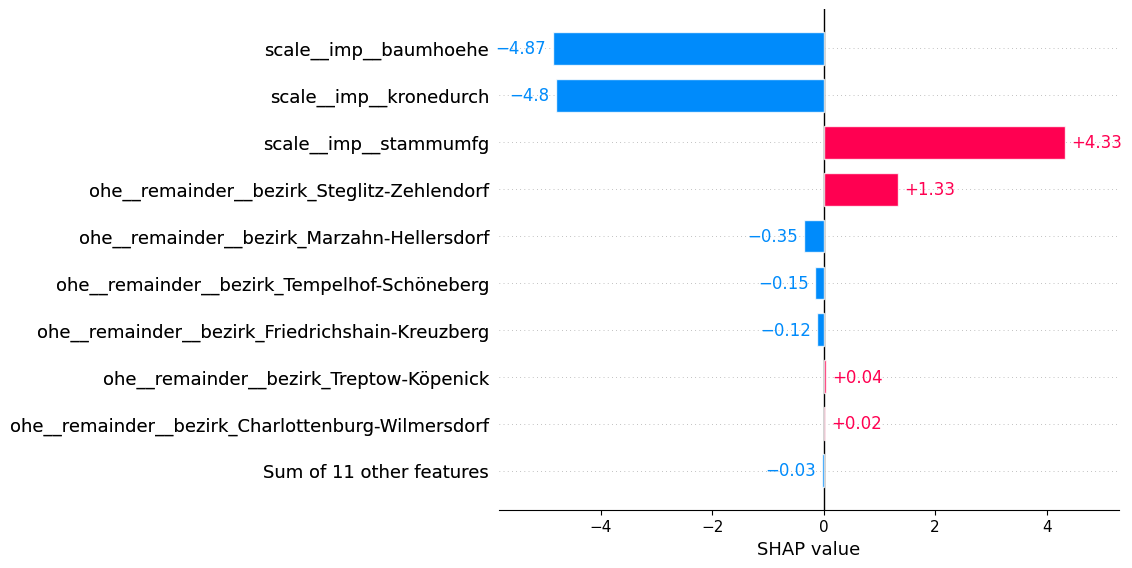

In [32]:
shap.plots.bar(shap_values=explanation_3[20002])

### Force Plot

In [33]:
# load JS visualization code to notebook
shap.initjs()

In [34]:
ix = 20002  # <- einfach mal ein paar Beispiele angucken!

shap.force_plot(
    base_value=explainer_3.expected_value,
    shap_values=shap_values_test_3[ix, :],
    features=transformed_test_3.columns,
    figsize=(25, 3),
    # matplotlib=True,
)

In [35]:
shap.force_plot(
    base_value=explainer_3.expected_value,
    shap_values=shap_values_test_3[9874, :],
    features=transformed_test_3.columns,
    figsize=(25, 3),
    # matplotlib=True,
)